# Capstone Project: Amazon Review Classification (Part 2)
Author: **Steven Lee**

# Topic Modelling with Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is a popular probabilistic topic model in that it provides both a predictive and a latent topic representation of the corpus.  LDA from the gensim library will be used to extract topics from the Amazon reviews dataset (Tools and Home Improvement).  The review text has already been cleaned of duplicates, lemmatized and removed of stop words in a prior preprocessing notebook.  LDA considers every topic a collection of keywords in various proportions, and every document a collection of topics in various proportions.  All that is needed is to provide the algorithm a parameter of the number of topics and it will create an optimal keyword-topic distribution.

A good segregation of topics, depends on the following key factors:

- The quality of text processing.
- The variety of topics covered in the text.
- Choice of modelling algorithm.
- The number of topics parameter provided to the algorithm.
- The tunning parameters of the algorithm.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Tokenize-Documents" data-toc-modified-id="Tokenize-Documents-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Documents</a></span></li><li><span><a href="#Create-Bigrams" data-toc-modified-id="Create-Bigrams-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create Bigrams</a></span></li><li><span><a href="#Create-LDA-Dictionary-and-Corpus" data-toc-modified-id="Create-LDA-Dictionary-and-Corpus-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create LDA Dictionary and Corpus</a></span></li><li><span><a href="#Build-Baseline-Topic-Model" data-toc-modified-id="Build-Baseline-Topic-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build Baseline Topic Model</a></span></li><li><span><a href="#Compute-Baseline-Model-Coherence-Score" data-toc-modified-id="Compute-Baseline-Model-Coherence-Score-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compute Baseline Model Coherence Score</a></span></li><li><span><a href="#Build-Mallet's-LDA-Model" data-toc-modified-id="Build-Mallet's-LDA-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Build Mallet's LDA Model</a></span></li><li><span><a href="#Compare-Mallet's-Model-Coherence-Score" data-toc-modified-id="Compare-Mallet's-Model-Coherence-Score-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Compare Mallet's Model Coherence Score</a></span></li><li><span><a href="#Visualize-Topics-and-Keywords" data-toc-modified-id="Visualize-Topics-and-Keywords-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Visualize Topics and Keywords</a></span></li><li><span><a href="#Prepare-Data-for-Visualizations" data-toc-modified-id="Prepare-Data-for-Visualizations-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Prepare Data for Visualizations</a></span></li><li><span><a href="#Consolidate-Topic-Data" data-toc-modified-id="Consolidate-Topic-Data-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Consolidate Topic Data</a></span></li><li><span><a href="#Save-Data-to-File" data-toc-modified-id="Save-Data-to-File-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Save Data to File</a></span></li></ul></div>

## Import Libraries

In [1]:
import pandas as pd
from random import sample

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Set pandas display options.
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.width', 120)

# Set Seaborn plot (default) to display grid over white background.
sns.set_style('whitegrid')

# Enable plots with higher resolution.
%config InlineBackend.figure_format = 'retina'

# Set output of plots to display inline directly below the code cell that produced it.
%matplotlib inline

from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore, CoherenceModel
import gensim.corpora as corpora
import gensim

import os
import pyLDAvis
import pyLDAvis.gensim
import pickle 

from wordcloud import WordCloud
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from collections import Counter

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

## Prepare Data

In [2]:
# Read in clean reviews dataset.
reviews = pd.read_csv("../data/reviews_clean.csv")

In [3]:
# Check product categories.
reviews['main_cat'].value_counts()

Tools & Home Improvement     1199885
Sports & Outdoors              73750
Amazon Home                    73204
Industrial & Scientific        62453
Automotive                     32150
Office Products                 5718
Home Audio & Theater            3871
Arts, Crafts & Sewing           3747
Musical Instruments             3669
All Electronics                 2473
Baby                            2356
Toys & Games                    2318
Amazon Fashion                  2233
Health & Personal Care          2121
Computers                       1847
Camera & Photo                  1777
Cell Phones & Accessories       1773
All Beauty                       994
Pet Supplies                     902
Car Electronics                  630
Grocery                          207
Appliances                        98
Video Games                       50
Handmade                          23
Amazon Devices                    21
Books                             16
GPS & Navigation                   9
D

In [4]:
# Drop null document values and reset index.
reviews.dropna(subset=['document'], inplace=True)
reviews.reset_index(drop=True, inplace=True)
reviews.shape

(1477655, 6)

In [5]:
reviews.head(3)

,overall,reviewText,word_cnt,brand,main_cat,document
0,5.0,"returned, decided against this product",5,SioGreen,Tools & Home Improvement,returned decided product
1,5.0,Awesome heater for the electrical requirements! Makes an awesome preheater for my talnkless system,14,SioGreen,Tools & Home Improvement,awesome heater electrical requirement make awesome preheater talnkless system
2,5.0,Keeps the mist of your wood trim and on you. Bendable too.,12,SioGreen,Tools & Home Improvement,keep mist wood trim bendable


In [6]:
# Print sameple document for subsequent checks.
reviews[reviews['document'].index == 3].values[0][1]

'So far I hooked it up and tested it , filled a five gallon bucket with hot water, it is the perfect temp for a shower,the flow valve that came with it broke when i tried to tighten it to get it to stop leaking,just hooked it directly to sharkbite pex fitting,seems to work fine without the valve. it is hooked up to a 2 poll 20 amp breaker, will have to wait till the rest of my bathroom is finished to give a better review.'

In [7]:
documents = reviews['document'].values.tolist()
documents[3][:25]

'hooked tested filled five'

In [8]:
# Remove reviews df from memory.
del reviews

## Tokenize Documents

In [9]:
# Custom function to tokenize review documents.
def tokenize_docs(documents):
    for doc in documents:
        yield(simple_preprocess(str(doc)))

In [10]:
word_tokens = list(tokenize_docs(documents))
word_tokens[:][3][:4]

['hooked', 'tested', 'filled', 'five']

## Create Bigrams

Gensim’s Phrases model will be used to create bigrams in the documents.  Min_count and threshold are two important parameters to tune the Phrases model.  Higher values result in fewer bigrams created.

In [11]:
# Build bigram model and custom function to create bigrams.
bigrams = gensim.models.Phrases(word_tokens, min_count=5, threshold=100)    # Higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigrams)

def create_bigrams(documents):
    return [bigram_model[doc] for doc in documents]

In [12]:
# Create Bigrams.
bigram_tokens = create_bigrams(word_tokens)
bigram_tokens[:][3][:4]

['hooked', 'tested', 'filled', 'five']

## Create LDA Dictionary and Corpus

A dictionary of every word in the documents will be created, and each word will be assigned an unique Id.  The corpus or bag of words will consist of word Id and frequency mappings.  For example (5, 2), word Id 5 occurred twice in a document, etc..

In [13]:
# Create dictionary.
id2word = corpora.Dictionary(bigram_tokens)

# Filter out extremes.
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=150000)

# Generate term document frequencies.
corpus = [id2word.doc2bow(doc) for doc in bigram_tokens]
corpus[:][3][:4]

[(14, 1), (15, 1), (16, 1), (17, 1)]

## Build Baseline Topic Model

Both dictionary and corpus, as well as, the number of topics, are required to build the LDA model.

In [14]:
# Optimal number of topics based on Topic Coherence score.  See section below.
num_topics = 30

# Build LDA model
%time lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42) 

Wall time: 2min 22s


In [15]:
# Display top 10 keywords (KW) and contribution/weightage (WT) for all topics.
keywords = lda_model.show_topics(num_topics=num_topics, formatted=False)

df = [[] for i in range(num_topics)]
for i in range(num_topics):
    cols = []
    cols.append("T{:02d}-KW".format(i))
    cols.append("T{:02d}-WT".format(i))
    df[i] = pd.DataFrame(keywords[i][1], columns=cols)
    if i == 0:
        top_keywords = df[i]
    else:
        top_keywords = pd.concat([top_keywords, df[i]], axis=1)

top_keywords.to_csv("../data/keywords_lda.csv", index=False)
top_keywords

,T00-KW,T00-WT,T01-KW,T01-WT,T02-KW,T02-WT,T03-KW,T03-WT,T04-KW,T04-WT,T05-KW,T05-WT,T06-KW,T06-WT,T07-KW,T07-WT,T08-KW,T08-WT,T09-KW,T09-WT,T10-KW,T10-WT,T11-KW,T11-WT,T12-KW,T12-WT,T13-KW,T13-WT,T14-KW,T14-WT,T15-KW,T15-WT,T16-KW,T16-WT,T17-KW,T17-WT,T18-KW,T18-WT,T19-KW,T19-WT,T20-KW,T20-WT,T21-KW,T21-WT,T22-KW,T22-WT,T23-KW,T23-WT,T24-KW,T24-WT,T25-KW,T25-WT,T26-KW,T26-WT,T27-KW,T27-WT,T28-KW,T28-WT,T29-KW,T29-WT
0,tool,0.061238,cord,0.035106,floor,0.020725,knife,0.055328,light,0.043770,love,0.084106,glove,0.032383,heavy,0.038371,light,0.143290,color,0.070226,used,0.020436,much,0.020535,clamp,0.015137,worked,0.073954,bulb,0.114529,work,0.028658,wire,0.041968,well,0.173545,blade,0.061679,water,0.069455,door,0.089131,would,0.020045,work,0.022885,quality,0.054933,doe,0.091000,plastic,0.049814,easy,0.131663,great,0.160685,month,0.037972,kitchen,0.034225
1,small,0.019492,power,0.030954,amazing,0.019160,pocket,0.025956,lamp,0.031042,bought,0.034774,hose,0.030977,like,0.031089,bright,0.046426,look,0.057222,charging,0.014552,make,0.017638,make,0.014952,great,0.041885,light,0.051694,post,0.018878,hole,0.039095,made,0.069326,cut,0.021822,shower,0.043599,lock,0.049376,product,0.018554,device,0.022821,price,0.036807,work,0.040356,glass,0.040726,install,0.085390,good,0.087491,year,0.031604,cabinet,0.028975
2,screw,0.018056,outlet,0.028747,get,0.016374,sharp,0.023797,room,0.024292,house,0.025758,hand,0.026010,hold,0.017546,battery,0.046093,white,0.035141,work,0.014164,easier,0.013637,board,0.013443,work,0.041814,fixture,0.020477,glue,0.017194,screw,0.035431,work,0.058940,table,0.020973,head,0.028218,open,0.031548,review,0.018151,cable,0.022162,best,0.031093,money,0.035604,cheap,0.032622,garage,0.033429,work,0.080553,drill,0.027793,tape,0.025028
3,size,0.015569,plug,0.027633,great,0.014708,blade,0.018133,cool,0.014527,gift,0.024457,good,0.015086,duty,0.017057,flashlight,0.017499,nice,0.022455,solder,0.014151,would,0.011645,project,0.011973,fine,0.032598,watt,0.015197,edge,0.016042,wall,0.026814,seems,0.027503,cutting,0.020333,filter,0.023277,easy,0.018542,time,0.016905,wire,0.013790,high,0.024059,like,0.021646,metal,0.026265,work,0.029683,price,0.068186,working,0.027176,faucet,0.023164
4,wrench,0.015215,would,0.018060,clean,0.013700,carry,0.017929,night,0.014488,awesome,0.015401,wear,0.013439,feel,0.015408,night,0.012844,like,0.019148,repair,0.014097,work,0.011435,thermostat,0.011928,long,0.024024,warm,0.013863,well,0.014134,bathroom,0.025761,sturdy,0.019484,dewalt,0.012740,switch,0.014691,close,0.015685,star,0.015117,great,0.010833,ve,0.022344,supposed,0.018876,toilet,0.025113,remote,0.025623,product,0.066221,unit,0.023879,paint,0.019174
5,great,0.014989,need,0.017065,quiet,0.013522,clip,0.017868,really,0.013820,around,0.014629,drawer,0.013259,magnet,0.013094,great,0.012424,great,0.017840,nail,0.013075,time,0.010846,work,0.011566,nice,0.018230,color,0.012477,stone,0.013681,strip,0.015989,built,0.019379,tool,0.011816,pressure,0.014166,knob,0.013996,received,0.013616,timer,0.010795,brand,0.017644,tool,0.018629,made,0.018136,great,0.023932,quality,0.033158,work,0.021604,spray,0.017172
6,bit,0.014037,little,0.016829,tile,0.012601,tool,0.017122,bright,0.013754,christmas,0.014234,pair,0.012830,solid,0.012312,work,0.011080,picture,0.016300,compressor,0.010200,little,0.010595,wood,0.011118,well,0.016933,much,0.012471,thread,0.010617,look,0.013459,nice,0.018508,used,0.010852,work,0.012052,front,0.012802,item,0.013162,connector,0.010538,better,0.014671,great,0.017856,one,0.017965,button,0.022416,fast,0.018319,still,0.019608,finish,0.015047
7,nice,0.013997,extension,0.014976,done,0.011550,little,0.015317,like,0.011739,loved,0.013555,large,0.012355,good,0.012168,charge,0.010251,black,0.016102,soldering,0.009294,better,0.010048,great,0.009069,room,0.015296,incandescent,0.011796,fine,0.009284,mounting,0.012437,look,0.018074,accurate,0.010751,flow,0.011506,great,0.011918,amazon,0.011757,meter,0.010230,tool,0.014399,need,0.017003,seat,0.016041,instruct

## Compute Baseline Model Coherence Score

Coherence score measures the relative distance between words.  The overall coherence score of a topic is the average of the distances between words.

In [18]:
%%time

# Compute Perplexity, a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score.
coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.024775474095573

Coherence Score:  0.5028834866953109
Wall time: 8min 53s


## Build Mallet's LDA Model

In [18]:
mallet_path = "C:/Users/Programs/Mallet/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=30, id2word=id2word, random_seed=42)

In [19]:
# Display Mallet's top 10 keywords (KW) and contribution/weightage (WT) for all topics.
keywords = ldamallet.show_topics(num_topics=num_topics, formatted=False)

df = [[] for i in range(num_topics)]
for i in range(num_topics):
    cols = []
    cols.append("T{:02d}-KW".format(i))
    cols.append("T{:02d}-WT".format(i))
    df[i] = pd.DataFrame(keywords[i][1], columns=cols)
    if i == 0:
        top_keywords = df[i]
    else:
        top_keywords = pd.concat([top_keywords, df[i]], axis=1)

top_keywords

,T00-KW,T00-WT,T01-KW,T01-WT,T02-KW,T02-WT,T03-KW,T03-WT,T04-KW,T04-WT,T05-KW,T05-WT,T06-KW,T06-WT,T07-KW,T07-WT,T08-KW,T08-WT,T09-KW,T09-WT,T10-KW,T10-WT,T11-KW,T11-WT,T12-KW,T12-WT,T13-KW,T13-WT,T14-KW,T14-WT,T15-KW,T15-WT,T16-KW,T16-WT,T17-KW,T17-WT,T18-KW,T18-WT,T19-KW,T19-WT,T20-KW,T20-WT,T21-KW,T21-WT,T22-KW,T22-WT,T23-KW,T23-WT,T24-KW,T24-WT,T25-KW,T25-WT,T26-KW,T26-WT,T27-KW,T27-WT,T28-KW,T28-WT,T29-KW,T29-WT
0,screw,0.063176,battery,0.154570,review,0.051713,quality,0.158675,nice,0.093307,light,0.406667,ve,0.103003,easy,0.275634,wall,0.040404,thing,0.082171,power,0.065807,love,0.172736,tool,0.206369,doe,0.119286,hand,0.070197,money,0.063273,house,0.042885,flashlight,0.056944,work,0.342475,small,0.129042,water,0.088695,made,0.132888,good,0.323690,great,0.524615,hold,0.067958,blade,0.091281,product,0.197682,switch,0.072317,bulb,0.147139,door,0.097997
1,hole,0.054139,long,0.062114,amazon,0.043903,good,0.101314,bathroom,0.043099,bright,0.085560,year,0.092902,install,0.128198,paint,0.028556,problem,0.060851,wire,0.055371,bought,0.086488,drill,0.058016,make,0.036270,handle,0.059754,worth,0.053272,cover,0.031239,glass,0.036400,great,0.171099,size,0.096373,head,0.053094,plastic,0.073862,price,0.235178,work,0.335351,place,0.050712,knife,0.080150,item,0.075240,turn,0.044095,light,0.079111,unit,0.062254
2,inch,0.034561,month,0.058944,ordered,0.032406,recommend,0.084442,kitchen,0.038118,night,0.049542,time,0.052625,simple,0.038132,clean,0.028260,star,0.060275,plug,0.038503,room,0.060331,bit,0.032111,level,0.023969,lock,0.054240,time,0.051073,back,0.022229,bright,0.031265,worked,0.122559,nice,0.067407,shower,0.048997,cheap,0.060814,quality,0.064664,tape,0.033565,strong,0.032802,sharp,0.035414,happy,0.068314,setting,0.030052,lamp,0.052717,garage,0.045292
3,make,0.030848,time,0.043687,received,0.024473,heavy,0.064602,perfect,0.031565,dark,0.022125,bought,0.036995,installation,0.034149,stuff,0.025492,give,0.047365,cord,0.036015,perfect,0.036163,socket,0.028137,find,0.020160,feel,0.046590,bought,0.047647,inside,0.019225,nice,0.015943,fine,0.092995,perfect,0.058151,filter,0.039332,metal,0.051159,store,0.047624,awesome,0.013324,stay,0.025337,pocket,0.033338,purchase,0.059603,control,0.029450,color,0.052493,open,0.032568
4,table,0.025306,working,0.042917,return,0.021627,high,0.062234,cabinet,0.028307,area,0.019271,purchased,0.025773,instruction,0.033655,wood,0.020701,issue,0.031082,outlet,0.029687,awesome,0.025360,wrench,0.026249,line,0.019134,glove,0.033546,le,0.045839,problem,0.017230,beam,0.014857,perfectly,0.064141,case,0.035998,faucet,0.035218,part,0.039318,fast,0.046145,addition,0.010368,easily,0.025087,edge,0.028439,time,0.054390,heat,0.022182,white,0.038641,button,0.030249
5,clamp,0.022739,year,0.041548,replacement,0.021484,nice,0.050927,toilet,0.027148,turn,0.013193,shop,0.025409,installed,0.033460,stick,0.018175,pretty,0.024449,wall,0.020961,wife,0.022239,driver,0.021964,read,0.017981,grip,0.020962,cost,0.038025,make,0.013842,safety,0.014833,needed,0.061497,large,0.034128,sink,0.033969,piece,0.038220,shipping,0.030181,deal,0.009965,side,0.024877,cutting,0.028151,arrived,0.039555,device,0.019286,fixture,0.032796,model,0.028722
6,mount,0.019914,charge,0.031475,company,0.018569,highly,0.046189,design,0.026831,lighting,0.012197,project,0.023251,minute,0.025175,black,0.017034,reason,0.020563,strip,0.020376,gift,0.021666,dewalt,0.020136,supposed,0.017609,pair,0.017680,expensive,0.036786,bought,0.013519,comfortable,0.014686,expected,0.034843,smaller,0.031818,hose,0.032402,broke,0.022068,find,0.022402,idea,0.008604,floor,0.022114,clip,0.024215,purchased,0.036824,feature,0.019194,watt,0.021227,close,0.024874
7,side,0.018159,hour,0.031147,product,0.017617,product,0.045199,finish,0.024805,yard,0.010549,found,0.020997,super,0.023495,surface,0.016355,people,0.019693,cable,0.019959,thing,0.021641,bolt,0.019347,type,0.017416,make,0.017574,brand,0.036696,sound,0.012030,super,0.013275,working,0.023573,fit,0.030923,pressure,0.023513,break,0.02014

## Compare Mallet's Model Coherence Score

In [20]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=bigram_tokens, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6023959262180647


## Visualize Topics and Keywords

In [23]:
%%time

# Visualize the LDA topics.
pyLDAvis.enable_notebook()

# Initialise data file.
LDAvis_data_filepath = os.path.join("../ldavis/ldavis_bigrams_" + str(num_topics))

# Generate visualization data.
# Warning: Time consuming activity.  Negate condition to skip.
if 1 == 0:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from file.
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, "../ldavis/ldavis_bigrams_" + str(num_topics) +'.html')
LDAvis_prepared

Wall time: 29 ms


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.114087  0.120743       1        1  7.237614
21     0.057092  0.008653       2        1  5.849495
23     0.050273 -0.132873       3        1  5.464822
27     0.215171 -0.224594       4        1  4.782392
0     -0.110727 -0.093190       5        1  4.466149
14     0.138545  0.085446       6        1  4.343895
28     0.022654  0.089273       7        1  3.910650
7     -0.086968 -0.037211       8        1  3.784734
4      0.095457  0.096700       9        1  3.716995
3     -0.067967 -0.089833      10        1  3.640304
19     0.024950  0.134716      11        1  3.597721
17     0.070525 -0.154228      12        1  3.525282
11    -0.118432  0.054671      13        1  3.159511
26     0.064820  0.057544      14        1  3.125992
29    -0.042658 -0.003940      15        1  2.827288
1     -0.031069  0.059086      16        1  2.816735
16    -0.042056  0.068215      17        1  2.734569
18    -0.102141 -0.065868      18        1  2.724637
20     0.001313  0.070383      19        1  2.655582
24    -0.014847 -0.043256      20        1  2.617378
22     0.030965  0.091340      21        1  2.587455
6     -0.042508 -0.038994      22        1  2.576805
25    -0.070614 -0.079449      23        1  2.519743
12    -0.111279  0.021847      24        1  2.505718
5      0.025501 -0.004623      25        1  2.384153
13     0.098440 -0.003823      26        1  2.262730
9      0.101911 -0.006241      27        1  2.261072
2     -0.086845  0.006380      28        1  2.196858
10    -0.084547  0.044074      29        1  1.998854
15    -0.099045 -0.030947      30        1  1.724866, topic_info=         Term           Freq          Total Category  logprob  loglift
405     light  343306.000000  343306.000000  Default  30.0000  30.0000
525      bulb  119393.000000  119393.000000  Default  29.0000  29.0000
90       well  250324.000000  250324.000000  Default  28.0000  28.0000
88       easy  174262.000000  174262.000000  Default  27.0000  27.0000
171     great  402447.000000  402447.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
230  together    1948.900720   16922.391705  Topic30  -5.3368   1.8986
86      would    2836.738194  165850.814306  Topic30  -4.9614  -0.0084
65       good    3016.868619  259810.335811  Topic30  -4.8999  -0.3957
145    little    2523.762629  114687.053352  Topic30  -5.0783   0.2436
450      side    1903.134858   35295.300095  Topic30  -5.3606   1.1398

[2529 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
621       2  0.087507         aaa
621       3  0.876753         aaa
621      29  0.035339         aaa
164       1  0.034981  absolutely
164       2  0.016429  absolutely
...     ...       ...         ...
1158     30  0.000116      yellow
2236      1  0.098561   yellowish
2236      6  0.899371   yellowish
2236     26  0.001120   yellowish
4942     25  0.999298        zoom

[22568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 22, 24, 28, 1, 15, 29, 8, 5, 4, 20, 18, 12, 27, 30, 2, 17, 19, 21, 25, 23, 7, 26, 13, 6, 14, 10, 3, 11, 16])

In [16]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]    # More colors: 'mcolors.XKCD_COLORS'

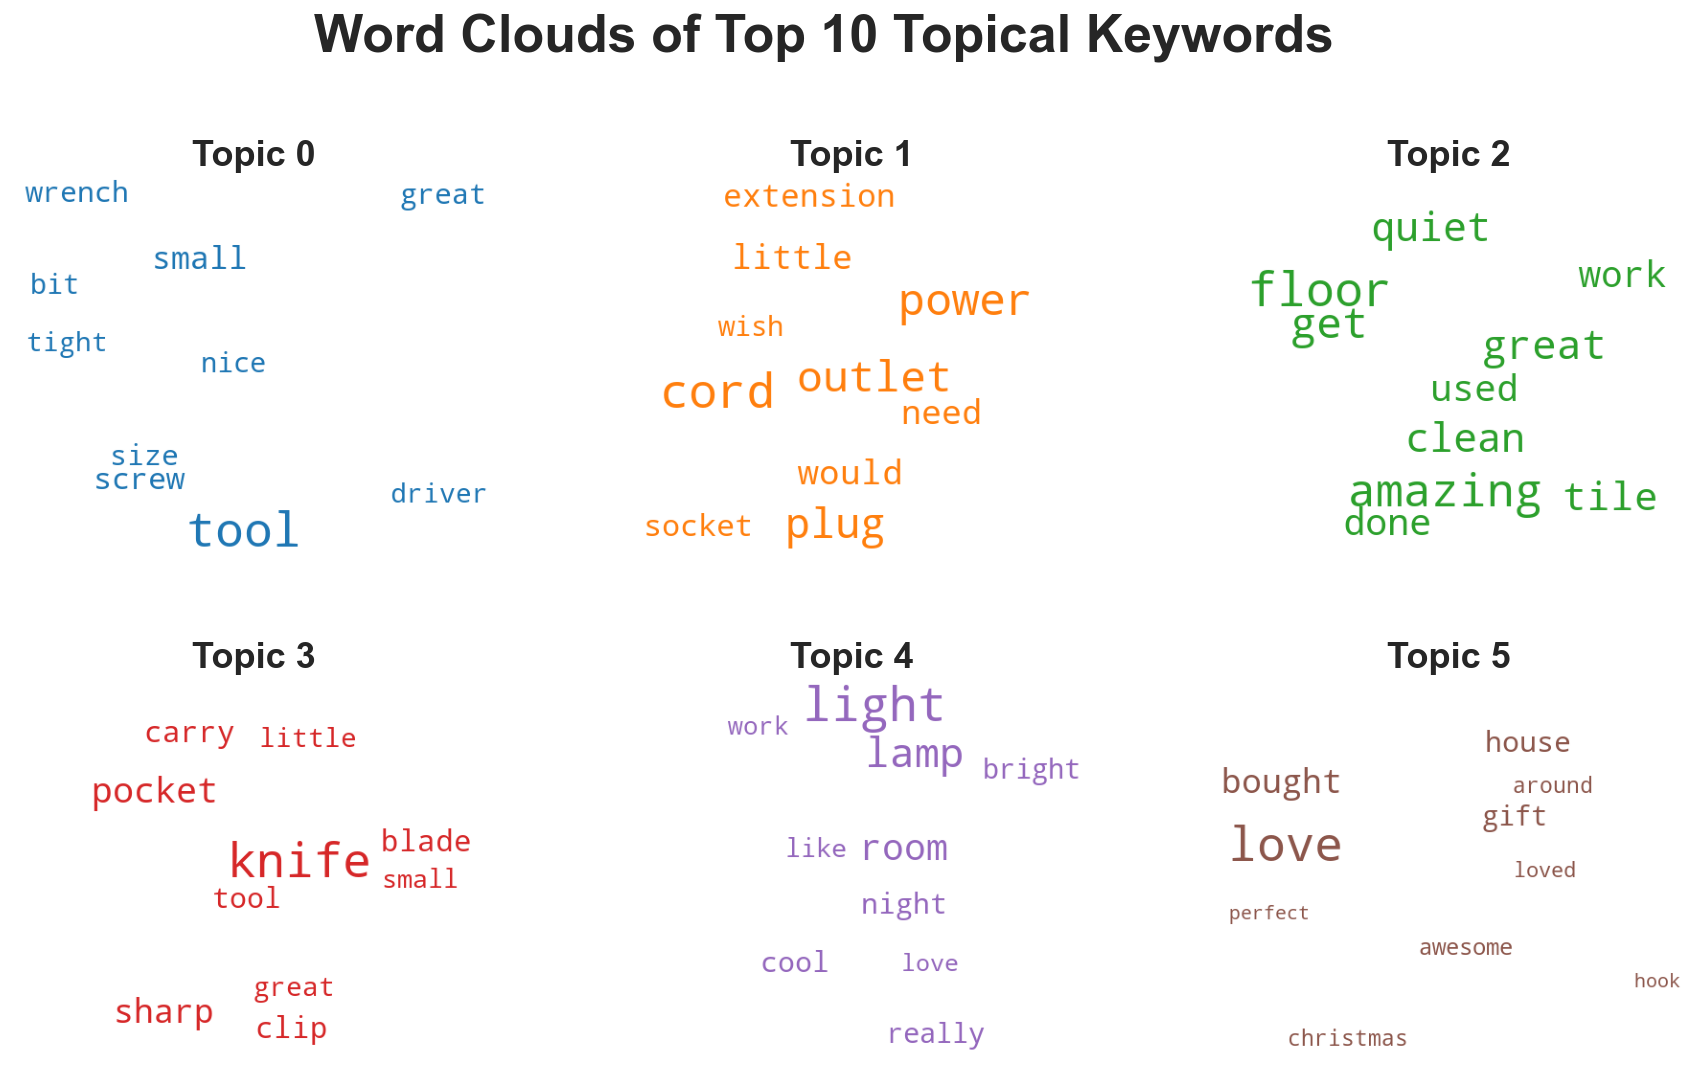

In [17]:
wordcloud = WordCloud(width=500, height=400, background_color='white', max_words=10, max_font_size=50, colormap='RdBu',
                      color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_keywords = dict(keywords[i][1])
    wordcloud.generate_from_frequencies(topic_keywords)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontsize=18, fontweight='bold')
    plt.gca().axis('off')

fig.subplots_adjust(top=0.9, hspace=0, wspace=0.25)
fig.suptitle("Word Clouds of Top 10 Topical Keywords", fontsize=26, fontweight='bold');

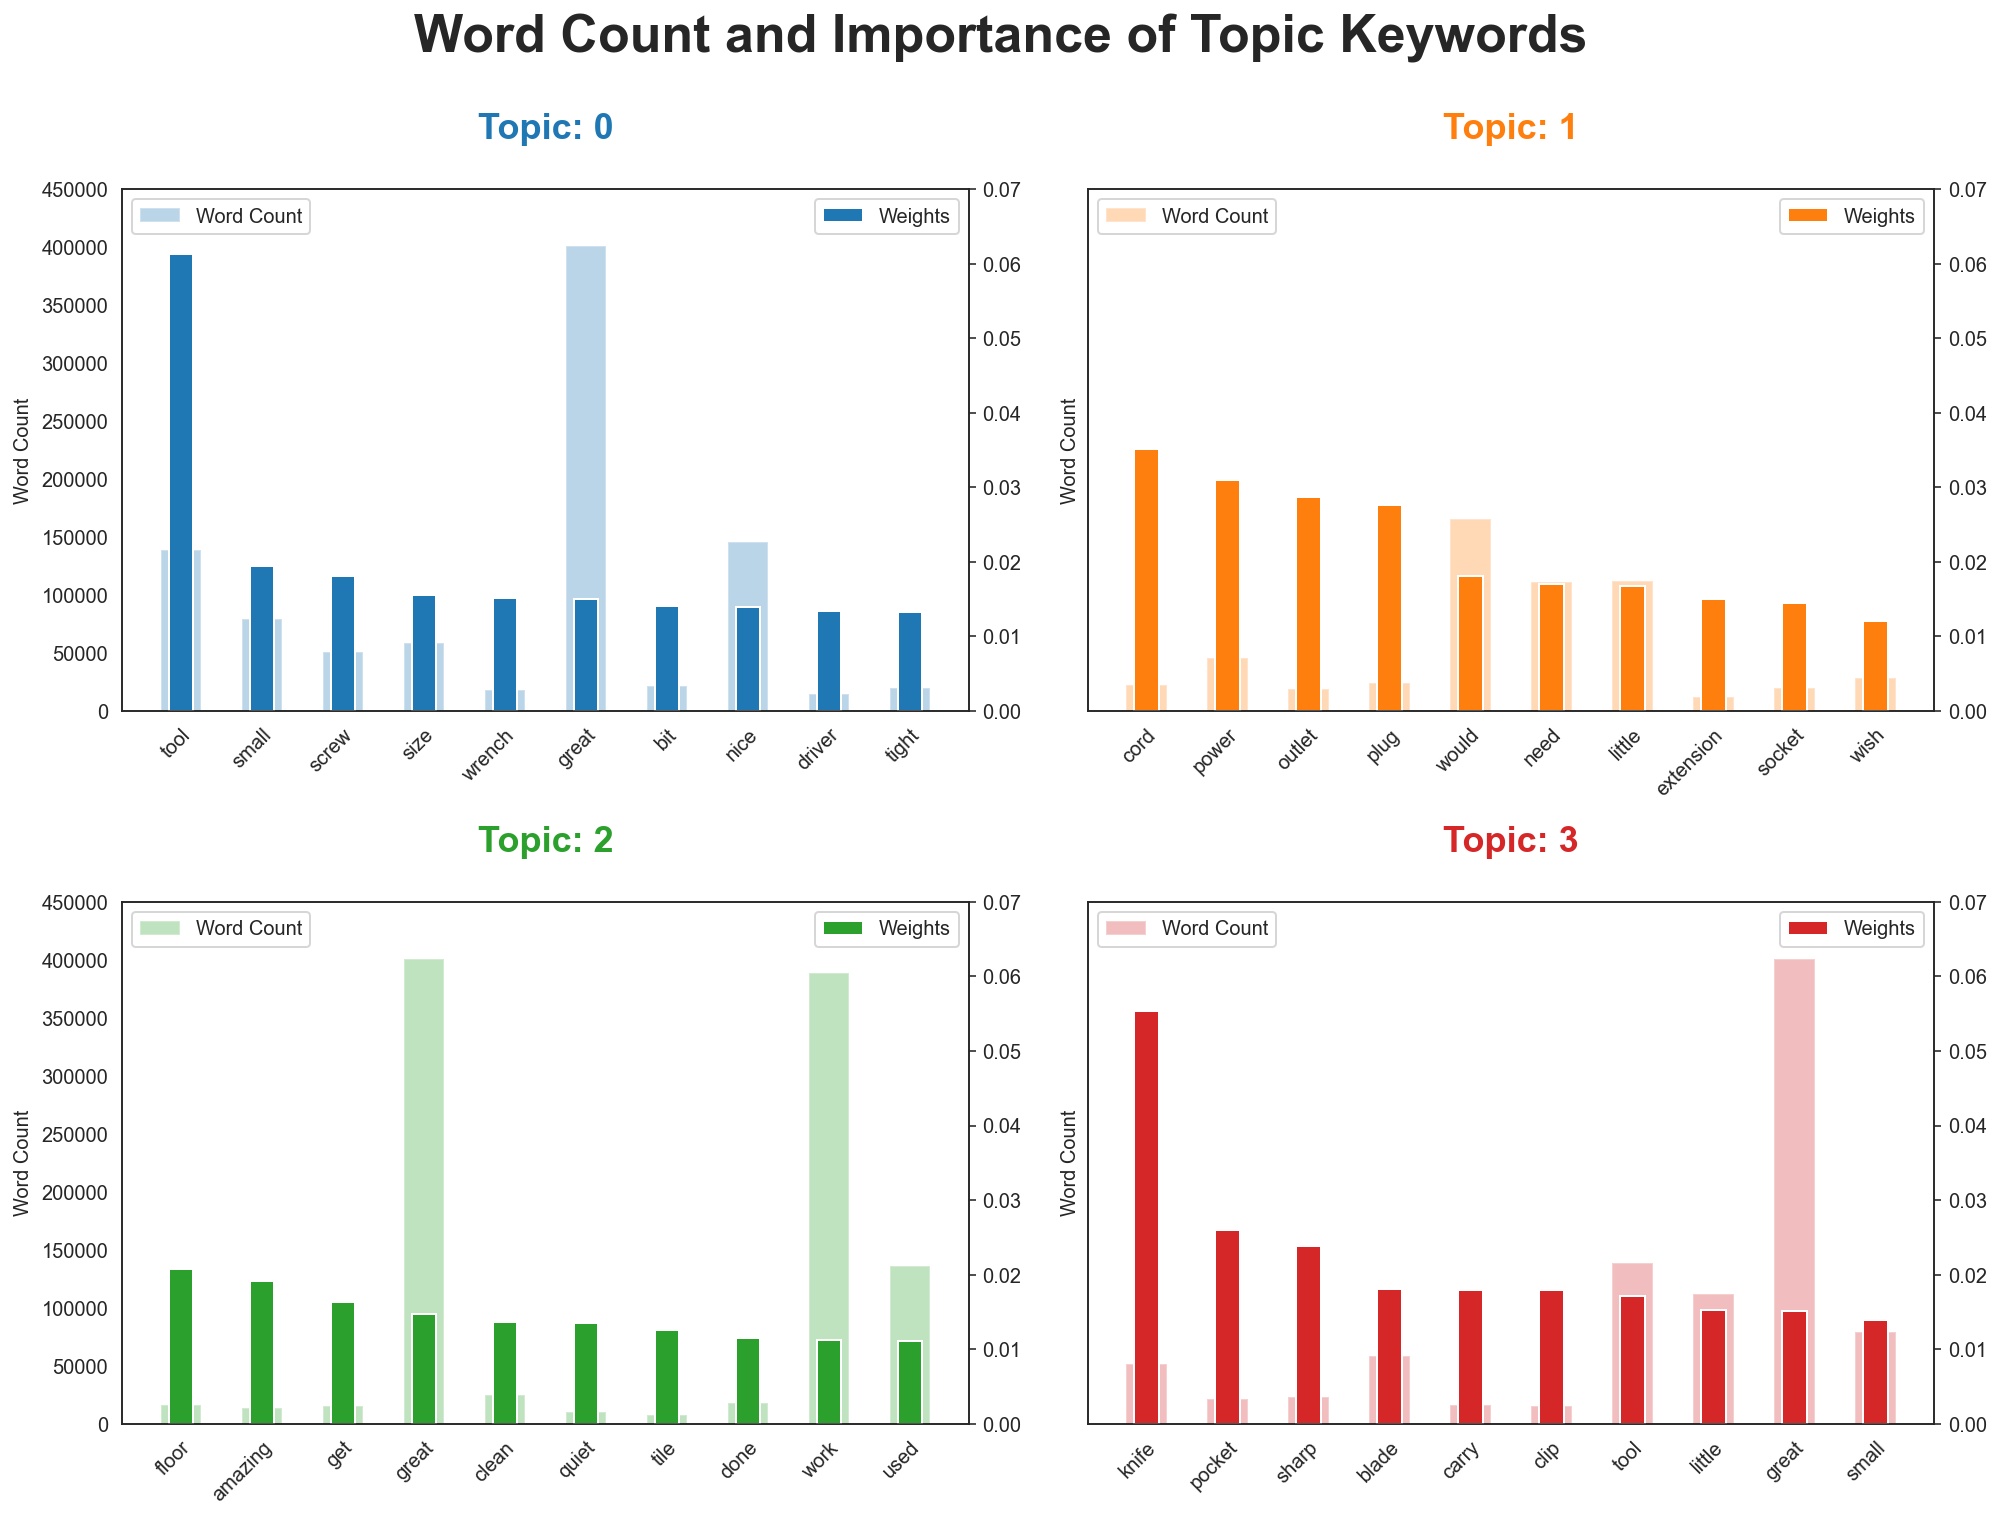

In [18]:
data = [w for w_list in bigram_tokens for w in w_list]
counter = Counter(data)

out = []
for i, keyword in keywords:
    for word, weight in keyword:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
sns.set_style('white')

# Plot word count and weights of topic keywords.
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.3, label='Weights')
    ax.set_ylabel('Word Count')
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=45, ha='right', rotation_mode='anchor')
    ax_twin.set_ylim(0, 0.07); ax.set_ylim(0, 450000)
    ax.set_title("Topic: " + str(i) + "\n", color=cols[i], fontsize=18, fontweight='bold')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=26, fontweight='bold', y=1.05);

In [169]:
# # Get topic weights
# topic_weights = []
# for row in enumerate(lda_model[corpus]):
#     topic_weights.append([w for i, w in row[1]])

# # Array of topic weights    
# arr = pd.DataFrame(topic_weights).fillna(0).values

# # Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# # Dominant topic number in each doc
# topic_num = np.argmax(arr, axis=1)

# # tSNE Dimension Reduction
# tsne_model = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')
# tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
# output_notebook()
# n_topics = 4
# mycolors = np.array(cols)
# plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=mycolors[topic_num])

IndexError: index 27 is out of bounds for axis 0 with size 10

## Prepare Data for Visualizations

In [19]:
# Re-read in clean reviews dataset.
reviews = pd.read_csv("../data/reviews_clean.csv")

In [20]:
# Drop null document values and reset index.
reviews.dropna(subset=['document'], inplace=True)
reviews.reset_index(drop=True, inplace=True)
reviews.shape

(1477655, 6)

In [21]:
# Custom function to extract dominant topic and percentage contribution.
def get_dmnt_topic():
    dmnt_topic = []
    pct_contrib = []
    
    for i, topics in enumerate(lda_model[corpus]):
        dmnt_top = max(topics, key=lambda x: x[1])
        dmnt_topic.append(dmnt_top[0])
        pct_contrib.append(round(dmnt_top[1], 4))
    
    return dmnt_topic, pct_contrib

## Consolidate Topic Data

The LDA model has been created with the number of topics as provided as a parameter.  Each topic consists of a combination of keywords in different proportions or percentage contributions.  The is can be seen as printed out below.

In [22]:
# Create new columns for dominant topic and percentage contribution.
%time reviews['dmnt_topic'], reviews['pct_contrib'] = get_dmnt_topic()

Wall time: 6min 11s


In [23]:
# Convert categories to numeric.
reviews['category'] = reviews['main_cat'].map({
    "Tools & Home Improvement": 27, "Sports & Outdoors": 26, "Amazon Home": 25, "Industrial & Scientific": 24, "Automotive": 23, "Office Products": 22, 
    "Home Audio & Theater": 21, "Arts, Crafts & Sewing": 20, "Musical Instruments": 19, "All Electronics": 18, "Baby": 17, "Toys & Games": 16, 
    "Amazon Fashion": 15, "Health & Personal Care": 14, "Computers": 13, "Camera & Photo": 12, "Cell Phones & Accessories": 11, "All Beauty": 10, 
    "Pet Supplies": 9, "Car Electronics": 8, "Grocery": 7, "Appliances": 6, "Video Games": 5, "Handmade": 4, "Amazon Devices": 3, "Books": 2, 
    "GPS & Navigation": 1, "Digital Music": 0
})

# Reorder columns.
cols = ['dmnt_topic', 'pct_contrib', 'reviewText', 'main_cat', 'category', 'brand', 'document', 'word_cnt', 'overall']
reviews = reviews[cols]
reviews.head(3)

,dmnt_topic,pct_contrib,reviewText,main_cat,category,brand,document,word_cnt,overall
0,21,0.7583,"returned, decided against this product",Tools & Home Improvement,27,SioGreen,returned decided product,5,5.0
1,22,0.3845,Awesome heater for the electrical requirements! Makes an awesome preheater for my talnkless system,Tools & Home Improvement,27,SioGreen,awesome heater electrical requirement make awesome preheater talnkless system,14,5.0
2,13,0.8389,Keeps the mist of your wood trim and on you. Bendable too.,Tools & Home Improvement,27,SioGreen,keep mist wood trim bendable,12,5.0


In [24]:
# Group top 5 sentences under each topic.
top5_topic_text = pd.DataFrame()

dmnt_topic_grps = reviews.groupby('dmnt_topic')

for i, grp in dmnt_topic_grps:
    top5_topic_text = pd.concat([top5_topic_text, grp.sort_values(['pct_contrib'], ascending=[0]).head(5)], axis=0)

# Reset df index.
top5_topic_text.reset_index(drop=True, inplace=True)

Wall time: 548 ms


In [25]:
top5_topic_text.loc[:, ['dmnt_topic', 'pct_contrib', 'reviewText']][65:70]

,dmnt_topic,pct_contrib,reviewText
65,13,0.9355,"Used this to create a ""zoo"" toy box for my gra..."
66,13,0.9355,We had wood flooring installed and needed felt...
67,13,0.9309,"The pads worked great, stayed where I put them..."
68,13,0.9309,We're finishing up our basement and we needed ...
69,13,0.9270,These chair foot cover floor protectors are gr...


In [24]:
# Create df with total number of documents per topic.
docs_topic = reviews['dmnt_topic'].value_counts()
topics = pd.DataFrame({ 'Dmnt_Topic': docs_topic.index, 'Total_Docs': docs_topic })

# Get percentage of documents per topic and sort df index.
topics['Pct_Docs'] = np.round(topics['Total_Docs'].values / topics['Total_Docs'].values.sum(), 4)
topics.sort_index(inplace=True)

# Custom function to get string of topic keywords from LDA model.
def get_topic_keywords():
    keywords = []
    for i in range(30):
        keywords.append(", ".join([word for word, prop in lda_model.show_topic(i)]))
        
    return keywords

# Insert topic keywords in df.
topics['Keywords'] = get_topic_keywords()

# Reorder and display df columns.
cols = ['Dmnt_Topic', 'Keywords', 'Total_Docs', 'Pct_Docs']
topics = topics[cols]

# Save LDA data to file.
topics.to_csv("../data/topics_lda.csv", index=False)

topics.head(5)

,Dmnt_Topic,Keywords,Total_Docs,Pct_Docs
0,0,"tool, small, screw, size, wrench, great, bit, nice, driver, tight",75782,0.0513
1,1,"cord, power, outlet, plug, would, need, little, extension, socket, wish",36298,0.0246
2,2,"floor, amazing, get, great, clean, quiet, tile, done, work, used",22762,0.0154
3,3,"knife, pocket, sharp, blade, carry, clip, tool, little, great, small",58888,0.0399
4,4,"light, lamp, room, cool, night, really, bright, like, work, love",49712,0.0336


## Save Data to File

In [25]:
# Save LDA data to file.
reviews.to_csv("../data/reviews_lda.csv", index=False)